# Multiclass image segmentation for ultrasound images

__Load Libraries__

In [52]:
%load_ext autoreload
%autoreload 3

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from glob import glob
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set Path

In [53]:
dir = os.getcwd()
parent_dir = os.path.dirname(dir)

PATH = parent_dir + '/data/fat_muscle'                             
PATH_IMAGES = PATH + '/images/'
PATH_MASKS = PATH + '/masks/'
PATH_PREDICTIONS = PATH + '/predictions' 

import sys
sys.path.append(parent_dir)

## Import custom functions

In [54]:
#from scripts
from library.data_preprocessing_multiclass import load_data, tf_dataset, read_image, read_original_size
from library.data_augmentation import augment_data, load_augmented_x_train_y_train, create_dir
from library.models import unet_large, mobile_netv2
from library.metrics import *
from library.visualisation_multiclass import *

# Define Hyperparemeters

In a first step, we can define some hyperparameters:
- **Shape**:  The shape of the images we feed into the model
- **Num_classes**: How many classes do we try to predict?
- **BATCH**: Batch Size
- **Epochs**: For how many epochs do we train our model
- **learning_rate**: reasonable values: 1e-4 for mobile_netv2, 1e-5 for Unet_large

In [71]:
#Define amount of classes the model should predict, the height (H) and width (W) of the image.
num_classes = 3
H=256 
W=256
shape = (W, H, num_classes)


#Define the batch size, for how many epochs we want to train our model and the learning_rate.
BATCH = 4
epochs = 10
learning_rate = 1e-4

## Load Data
Now, we can load the data and split them into train, validation and testing set. Per default, the train / val / test-split is 80% / 10% /10%. If required, this can be adapted by changing 'split = 0.1' to the desired degree.

In [56]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path_images = PATH_IMAGES, path_masks = PATH_MASKS, split = 0.1)
print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

Dataset: Train: 15 - Valid: 1 - Test: 1


## Data Augmentation 

Data Augmentation allows to increase the diversity of the data in our trainingset by applying realistic transformations, like rotation or chagning the brightness.

### Create folders for augmented images & masks

If the folder structure for the augmented images do not already exists, use the following code:

In [57]:
#function creates a directory or path with the needed structure
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

Now pass the path to the function to create one  folder each for augmented masks & images.

In [58]:
""" Creating folders for augmented images & masks. """
create_dir(PATH + '/augmented_data/images')
create_dir(PATH + '/augmented_data/masks')

We can now apply data augmentation to our training data. The function augment data applies the following augmentations:

 - RandomRotate90
 - Rotate(limit=45)
 - GridDistortion
 - ShiftScaleRotate
 - RandomBrightnessContrast
 - Crop
 
If other augmentations should be applied, change the **data_augmenation.py** script.

Check other augmentation techniques: https://albumentations-demo.herokuapp.com

In [62]:
augment_data(train_x, train_y, PATH + '/augmented_data/', augment=True)

100%|██████████| 15/15 [00:02<00:00,  5.35it/s]


We can now load the augmented images and masks as new train_x and train_y and check the size of our dataset:

In [63]:
train_x, train_y = load_augmented_x_train_y_train(PATH)
print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

Dataset: Train: 105 - Valid: 1 - Test: 1


## Create Datasets

As we have now the to correct splits and all data awe need, we can create the train_dataset, valid_dataset and test_dataset. To do so, use the function tf_dataset. This function loads the images and masks, resizes them to the defined size, normalizes images and performs one-hot encoding on the masks.

Check the **data_preprocessing_multiclasss.py** script to check the code in detail.

In [66]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH, width=W, height=H)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH, width=W, height=H)
test_dataset = tf_dataset(test_x, test_y, batch=BATCH, width=W, height=H)

## Model
Let's now define the model and metrics we are using to evaluate the performance of the models.

### Metrics
As metric to evaluate the performance of the model, the dice coef was used. The Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images. The dice coef allows thus to gauge the similarity of two samples.

While the dice_coef allows to monitor the overall performance, three seperate metrics were created to analyse, the performance for each class:

- **dice_coef_c1**: Not fat or muscle
- **dice_coef_c2**: Muscle
- **dice_coef_c3**: Fat

In [67]:
METRICS= [dice_coef, dice_coef_c1, dice_coef_c2, dice_coef_c3]

### Define Model
Now we define the model. Two diffrent Unet models are available for this task. As the name already suggests, the mobilenet model uses a pretrained mobilenet (trained on imagenet) as a decoder. The second model is a relatively large unet which was built from scratch. For the given task, of segmenting three diffrent classes, the performance of both models were quite similar.

- Check the sript models.py for exact model architecture.

In [68]:
""" Model 1"""
model = mobile_netv2(shape, num_classes)

2031616/2019640 [==============================] - 0s 0us/step


In [13]:
""" Model 2"""
#model = unet_large(shape, num_classes)

' Model 2'

### Compile Model
To train a model with fit(), we need to specify a loss function, an optimizer, and optionally, some metrics to monitor. We use the dice_loss as a oss function and the Adam algorithm as an optimizer. The learning_rate and the metrics were already defined.

In [69]:
model.compile(loss=dice_loss, optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=METRICS)

In [70]:
#summaries the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 16  64          ['Conv1[0][0]']                  
                                )                                                             

### Callbacks
Callbacks are objects that can perform tasks at various stages of the training process. The following call-backs are used during the training process:

- **ModelCheckpoint**: Saves the best model
- **ReduceLROnPlateau**: Reduce learning rate when a metric has stopped improving.
- **EarlyStopping**: Stop training when a monitored metric has stopped improving.

In [72]:
callbacks = [
        ModelCheckpoint(parent_dir + '/models/multiclass.h5',  verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor="val_loss", patience=10, verbose=1)
    ]

## Train the Model
We can now start with the training process of the mode. As a last step we define the train_steps and valid_steps and then pass all the needed arguments into the model.fit() function.

In [73]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

In [74]:
history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks
    )

Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 0.6777 - dice_coef: 0.3241 - dice_coef_c1: 0.4987 - dice_coef_c2: 0.3304 - dice_coef_c3: 0.1432
Epoch 1: val_loss improved from inf to 0.81182, saving model to c:\Users\rgris\projects\Propulsion-Academy-Final-Project/models\multiclass.h5
27/27 [==============================] - 71s 2s/step - loss: 0.6777 - dice_coef: 0.3241 - dice_coef_c1: 0.4987 - dice_coef_c2: 0.3304 - dice_coef_c3: 0.1432 - val_loss: 0.8118 - val_dice_coef: 0.1882 - val_dice_coef_c1: 0.2301 - val_dice_coef_c2: 0.2558 - val_dice_coef_c3: 0.0786 - lr: 1.0000e-04
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 0.5420 - dice_coef: 0.4586 - dice_coef_c1: 0.6573 - dice_coef_c2: 0.4970 - dice_coef_c3: 0.2216
Epoch 2: val_loss did not improve from 0.81182
27/27 [==============================] - 63s 2s/step - loss: 0.5420 - dice_coef: 0.4586 - dice_coef_c1: 0.6573 - dice_coef_c2: 0.4970 - dice_coef_c3: 0.2216 - val_loss: 0.8459 - val_dic

## Saving model and training history

The best model is already saved. If we want to track and save the training history (perfromance after each epoch) we can do that by applying the following code.

In [75]:
SAVEFILE_NAME = 'multiclass'
SAVE_FORMAT = 'h5'
path_model = os.path.join(parent_dir + '/models/', SAVEFILE_NAME)          

Full_history = {}
for x in history.history:
    Full_history[x]  = history.history[x] 

np.save(path_model+'_training_history.npy', Full_history)

__Load previous model and history__

If we want to continue training of a model which was already trained, use the following functions to reload the saved model:

In [108]:
# # load history
# Full_history = np.load(path_model+'_training_history.npy',allow_pickle='TRUE').item()
# print(Full_history.keys()) #prints keys
# # Load model
# model =  tf.keras.models.load_model(path_model+ '.' + SAVE_FORMAT, custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef,
#                                                                                    'dice_coef_c1': dice_coef_c1, 'dice_coef_c2':dice_coef_c2,
#                                                                                    'dice_coef_c3': dice_coef_c3}, compile=True)

dict_keys(['loss', 'dice_coef', 'dice_coef_c1', 'dice_coef_c2', 'dice_coef_c3', 'val_loss', 'val_dice_coef', 'val_dice_coef_c1', 'val_dice_coef_c2', 'val_dice_coef_c3', 'lr'])


## Plot training performance metrics

The training process is completed so let's plot the training performance metrics to analyse, how they have changed from epoch to epoch.

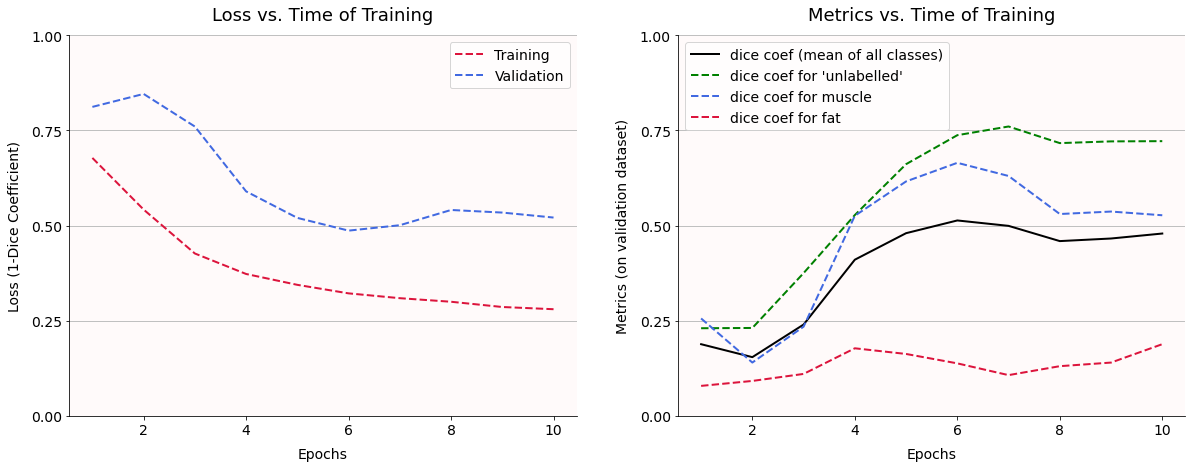

In [76]:
## Plot training history
training_loss = Full_history['loss']
validation_loss = Full_history['val_loss']
training_dice_coef = Full_history['dice_coef']
training_dice_coef_c1 = Full_history['dice_coef_c1']
training_dice_coef_c2 = Full_history['dice_coef_c2']
training_dice_coef_c3 = Full_history['dice_coef_c3']

## Plot validation history

validation_dice_coef = Full_history['val_dice_coef']
validation_dice_coef_c1 = Full_history['val_dice_coef_c1']
validation_dice_coef_c2 = Full_history['val_dice_coef_c2']
validation_dice_coef_c3 = Full_history['val_dice_coef_c3']


epoch_count = range(1, len(training_loss) + 1)
fig, axs = plt.subplots(1, 2, figsize = (20, 7))


# first supbplot for losses
axs[0].plot(epoch_count, training_loss, color = 'crimson', linestyle ='--', linewidth = 2)
axs[0].plot(epoch_count, validation_loss, color = 'royalblue', linestyle ='--', linewidth = 2)

axs[0].set_title('Loss vs. Time of Training', fontsize=18, pad=15)
axs[0].set_ylabel('Loss (1-Dice Coefficient)', fontsize=14, labelpad=10)
axs[0].set_xlabel('Epochs', fontsize=14, labelpad=10)
axs[0].legend(['Training', 'Validation'], fontsize=14)

axs[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[0].set_ylim((0,1))
axs[0].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axs[0].tick_params(labelsize=14)
axs[0].grid(which='both', axis='y', linewidth =1, color = 'silver')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].patch.set_facecolor('snow')


#validation loss

axs[1].plot(epoch_count, validation_dice_coef, color = 'black', linestyle ='-', linewidth = 2)
axs[1].plot(epoch_count, validation_dice_coef_c1, color = 'green', linestyle ='--', linewidth = 2)
axs[1].plot(epoch_count, validation_dice_coef_c2, color = 'royalblue', linestyle ='--', linewidth = 2)
axs[1].plot(epoch_count, validation_dice_coef_c3,  color = 'crimson', linestyle ='--', linewidth = 2)

axs[1].set_title('Metrics vs. Time of Training', fontsize=18, pad=15)
axs[1].set_ylabel('Metrics (on validation dataset)',  fontsize=14, labelpad=10)
axs[1].set_xlabel('Epochs', fontsize=14, labelpad=10)
axs[1].legend([ "dice coef (mean of all classes)", "dice coef for 'unlabelled'", "dice coef for muscle", "dice coef for fat"], fontsize=14)

axs[1].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[1].set_ylim((0,1))
axs[1].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axs[1].tick_params(labelsize=14)
axs[1].grid(which='both', axis='y', linewidth =1, color = 'silver')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].patch.set_facecolor('snow')

None

## Evaluate on test data

Evaluate the models performance on the test_dataset:

In [77]:
results = model.evaluate(test_dataset, steps=valid_steps)

1/1 [==============================] - 0s 181ms/step - loss: 0.4879 - dice_coef: 0.5121 - dice_coef_c1: 0.7448 - dice_coef_c2: 0.5705 - dice_coef_c3: 0.2210


## Predictions on test data
We can now make the predictions on the test_dataset. The predictions will be saved in the PATH_PREDICTIONS directory.

In [78]:
model_input_data = test_x  

for file_path in tqdm(model_input_data):
  file_name = os.path.basename(file_path)
  file_name, fileext = os.path.splitext(file_name)
  

  img = read_image(file_path, W, H)                           
  img = model.predict(np.expand_dims(img, axis=0))[0]                           
  img = np.argmax(img, axis=-1)                                                 
  img = np.expand_dims(img, axis=-1)
  img = img * (255/num_classes)                                                 
  img = np.concatenate([img, img, img], axis=2)                                 
  img = img.astype(np.uint8)
    
  orig_SIZE = read_original_size(file_path)
  img = cv2.resize(img, (orig_SIZE[0],                                         
                         orig_SIZE[1]), interpolation = cv2.INTER_NEAREST)                                      

  result_filepath = os.path.join(PATH_PREDICTIONS,"%s_prediction%s" % (file_name, fileext)) 
                    
  cv2.imwrite(result_filepath, img)

100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Were the predicted images created? The following coe checks, how many files are in the prediction folders. The amount of files should thus match the size of our test_dataset.

In [79]:
# check how many prediction images were created
pred_dir = glob(os.path.join(PATH_PREDICTIONS, '*.png'))
print(f"\n\n {len(pred_dir)} files in prediction folder")



 2 files in prediction folder


## Plotting

To get a feeling about how well the model predicted, we can now plot the images. To do so, we create four plots:

- **1. Original Image**
- **2. Original Mask (Ground truth)**
- **3. Prediction**
- **4. Prediction compared to ground truth**

In [80]:
# define color of labels:
mask_fat_color ='firebrick'
mask_muscle_color ='royalblue'                                                
contour_fat_color ='white'
contour_muscle_color ='white'

c:\Users\rgris\projects\Propulsion-Academy-Final-Project/data/fat_muscle/images/00001.png
c:\Users\rgris\projects\Propulsion-Academy-Final-Project/data/fat_muscle/masks/00001.png
c:\Users\rgris\projects\Propulsion-Academy-Final-Project/data/fat_muscle/predictions\00001_prediction.png


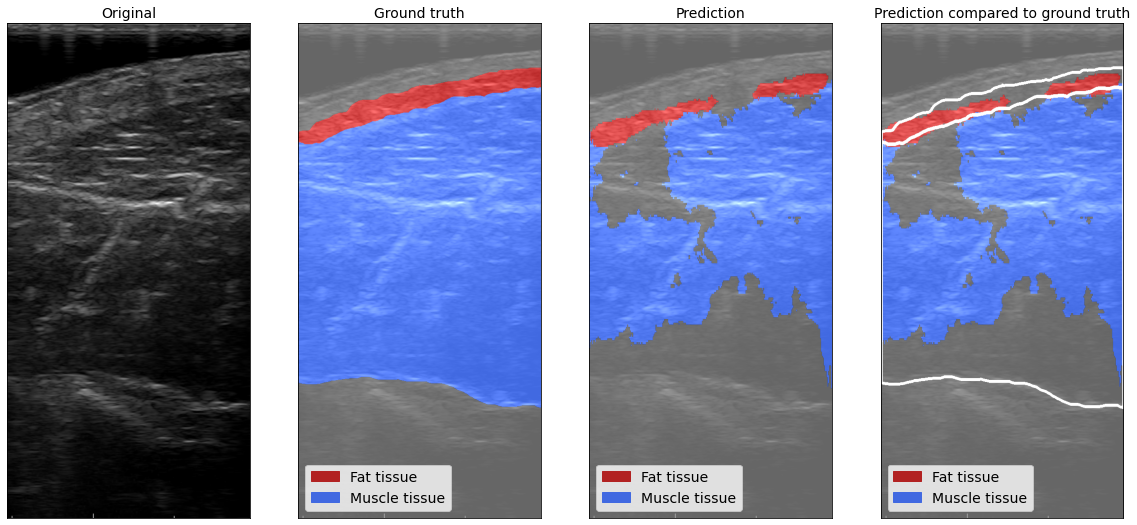

In [81]:
#define which image from Test_x should be plotted
plot_image = test_x[0] 

parent_directory = os.path.dirname(os.path.dirname(plot_image))
image_directory = parent_directory + '/images/'
mask_directory = parent_directory + '/masks/'
prediction_directory = PATH_PREDICTIONS
base_file = os.path.basename(plot_image)
file_name, fileext = os.path.splitext(base_file)
original_SIZE = read_original_size(plot_image) 

PLOTTING_WIDTH = round(original_SIZE[0])                                      # resizes the images for the plot
PLOTTING_HEIGHT = round(original_SIZE[1])


#path to image, mask, predicted mask
original_path = os.path.join(image_directory, base_file)
mask_image_path = os.path.join(mask_directory, base_file)
prediction_image_path = os.path.join(prediction_directory, "%s_prediction%s" % (file_name, fileext))

# read images as numpy arrays  
original = read_image_plotting(original_path, PLOTTING_WIDTH, PLOTTING_HEIGHT)
mask_area_image = create_overlay(mask_to_255(mask_image_path), PLOTTING_WIDTH, PLOTTING_HEIGHT, 
                            color1=mask_fat_color, color2=mask_muscle_color)

mask_outline_image = create_overlay(convert_mask_to_outline(mask_image_path, contour_width=6), 
                                    PLOTTING_WIDTH, PLOTTING_HEIGHT, color1=contour_fat_color, color2=contour_muscle_color)
prediction_image = create_overlay(Image.open(prediction_image_path), PLOTTING_WIDTH, PLOTTING_HEIGHT, 
                                  color1=mask_fat_color, color2=mask_muscle_color)



#create the overlay images  
merged_mask = cv2.addWeighted(mask_area_image, 1, original, 0.6, 0)                # choose level of transparency for first and second picture
merged_prediction = cv2.addWeighted(prediction_image, 1, original, 0.6, 0)
merged_prediction_mask = cv2.addWeighted(mask_outline_image, 1, prediction_image, 1, 0)
merged_image_both = cv2.addWeighted(merged_prediction_mask, 1, original, 0.6, 0)

######## create legend ########

colors = [mask_fat_color, mask_muscle_color]
texts = ["Fat tissue", "Muscle tissue"]
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]

########  plot  #########
fig, axs = plt.subplots(1, 4, figsize=(20, 12))

axs[0].set_title("Original", fontsize=14)
axs[0].imshow(original)
axs[0].tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

axs[1].set_title("Ground truth", fontsize=14)
axs[1].imshow(merged_mask)
axs[1].legend(handles=patches, bbox_to_anchor=(0.0, 0.0), loc='lower left', ncol=1, fontsize=14 )
axs[1].tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

axs[2].set_title("Prediction", fontsize=14)
axs[2].imshow(merged_prediction)
axs[2].legend(handles=patches, bbox_to_anchor=(0.0, 0.0), loc='lower left', ncol=1, fontsize=14 )
axs[2].tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

axs[3].set_title("Prediction compared to ground truth", fontsize=14)
axs[3].imshow(merged_image_both)
axs[3].legend(handles=patches, bbox_to_anchor=(0.0, 0.0), loc='lower left', ncol=1, fontsize=14 )
axs[3].tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)


print(original_path), print(mask_image_path),print(prediction_image_path)
None

Let's have a closer look where we focus on the top area of the image to see, how well the models can distinguish between muscvle and fat:

c:\Users\rgris\projects\Propulsion-Academy-Final-Project/data/fat_muscle/images/00001.png
c:\Users\rgris\projects\Propulsion-Academy-Final-Project/data/fat_muscle/masks/00001.png
c:\Users\rgris\projects\Propulsion-Academy-Final-Project/data/fat_muscle/predictions\00001_prediction.png


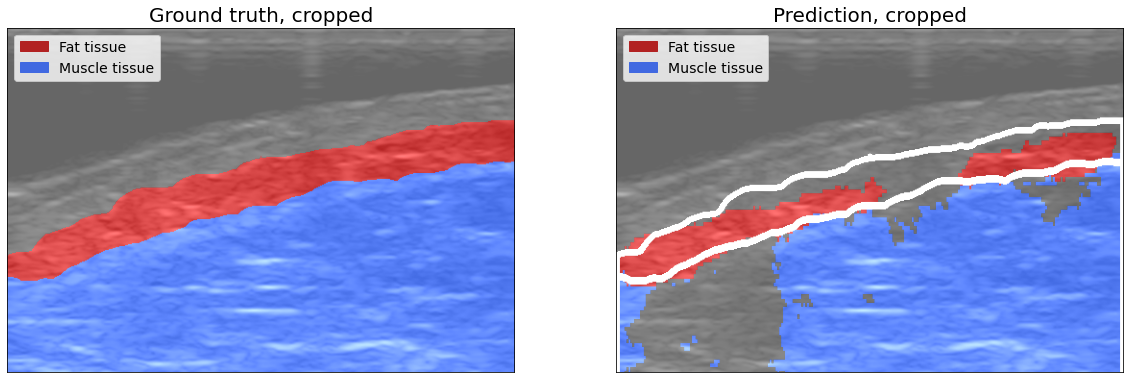

In [82]:
########### a closer look ##############
fig, ax2 = plt.subplots(1, 2, figsize=(20, 12))

ax2[0].set_title("Ground truth, cropped", fontsize=20)
ax2[0].imshow(crop_image(merged_mask, (0, 0, PLOTTING_WIDTH, PLOTTING_HEIGHT/3)))          # define cropping area (leftuppercorner(x,y), bottomrightcorner(x,y))
ax2[0].legend(handles=patches, bbox_to_anchor=(0.0, 1), loc='upper left', ncol=1, fontsize=14 )
ax2[0].tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

ax2[1].set_title("Prediction, cropped", fontsize=20)
ax2[1].imshow(crop_image(merged_image_both, (0, 0, PLOTTING_WIDTH, PLOTTING_HEIGHT/3)))
ax2[1].legend(handles=patches, bbox_to_anchor=(0.0, 1), loc='upper left', ncol=1, fontsize=14 )
ax2[1].tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)



print(original_path), print(mask_image_path),print(prediction_image_path)
None